https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-pytorch/

傅里叶变换 + CNN 处理音频

In [11]:
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

from torchvision import datasets, transforms
from torchvision import datasets, models, transforms
from torchinfo import summary

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

%pwd

'/home/cuilab/AAI2022Fall-Project/data_processing'

In [2]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    plt.figure()
    plt.plot(waveform.t().numpy())

    return waveform, sample_rate

Shape of waveform: torch.Size([1, 134640])
Sample rate of waveform: 16000


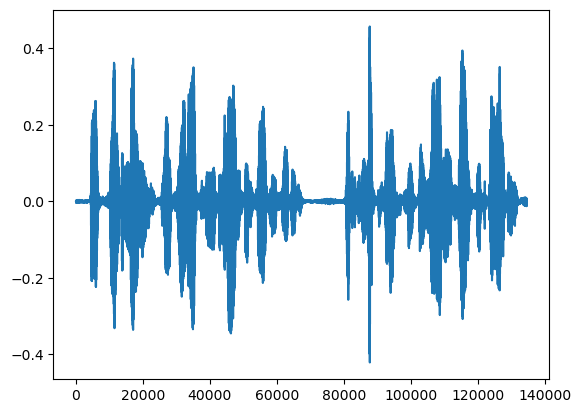

In [3]:
file_path = "../LibriSpeech-SI/train/spk001/spk001_002.flac"

waveform, sample_rate = plot_audio(file_path)

ipd.Audio(waveform.numpy(), rate=sample_rate)

In [4]:
def load_audio_files(path):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f"*.flac"))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_")
        speaker_id = int(speaker_id[3:])
        utterance_number = int(utterance_number)

        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, speaker_id, utterance_number])

    return dataset

In [5]:
data_spk1 = load_audio_files("../LibriSpeech-SI/train/spk001/")
data_spk2 = load_audio_files("../LibriSpeech-SI/train/spk002/")

print("Len of spk1 dataset:", len(data_spk1))
print("Len of spk2 dataset:", len(data_spk2))

Len of spk1 dataset: 100
Len of spk2 dataset: 102


Waveform shape: torch.Size([1, 134640])
Sample rate: 16000
Speaker: 001 

Shape of transformed waveform: torch.Size([1, 33660])
Sample rate: 4000


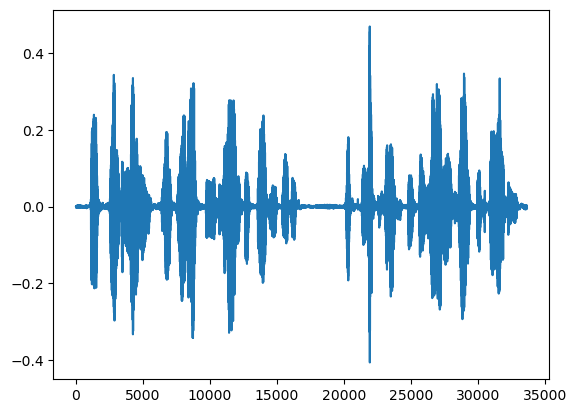

In [6]:
def show_waveform(waveform, sample_rate, speaker, factor):
    print(
        "Waveform shape: {}\nSample rate: {}\nSpeaker: {} \n".format(
            waveform.shape, sample_rate, speaker
        )
    )
    new_sample_rate = sample_rate // factor

    # Resample applies to a single channel, we resample first channel here
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(
        waveform[channel, :].view(1, -1)
    )

    print(
        "Shape of transformed waveform: {}\nSample rate: {}".format(
            waveform_transformed.size(), new_sample_rate
        )
    )

    plt.figure()
    plt.plot(waveform_transformed[0, :].numpy())

    return waveform_transformed, new_sample_rate


waveform_transformed, new_sample_rate = show_waveform(data_spk1[0][0], 16000, "001", 4)
ipd.Audio(waveform_transformed.numpy(), rate=new_sample_rate)  # must >= 3000hz


Shape of spectrogram: torch.Size([1, 201, 674])


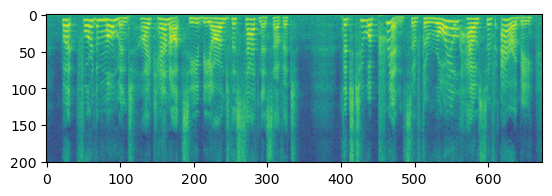

In [7]:
def show_spectrogram(waveform):
    spectrogram = torchaudio.transforms.Spectrogram()(waveform)
    print("\nShape of spectrogram: {}".format(spectrogram.size()))

    plt.figure()
    plt.imshow(spectrogram.log2()[0, :, :].numpy(), cmap="viridis")


show_spectrogram(data_spk1[0][0])

Shape of spectrogram: torch.Size([1, 128, 674])


/home/cuilab/miniconda3/envs/torch1.12/lib/python3.8/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


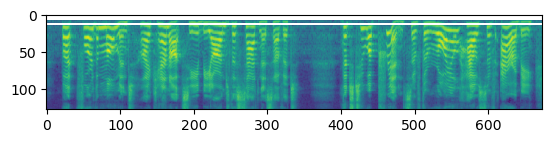

In [8]:
def show_melspectrogram(waveform, sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")


show_melspectrogram(data_spk1[0][0], 16000)

Shape of spectrogram: torch.Size([1, 40, 674])


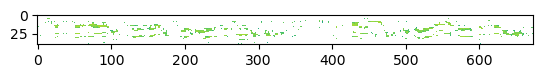

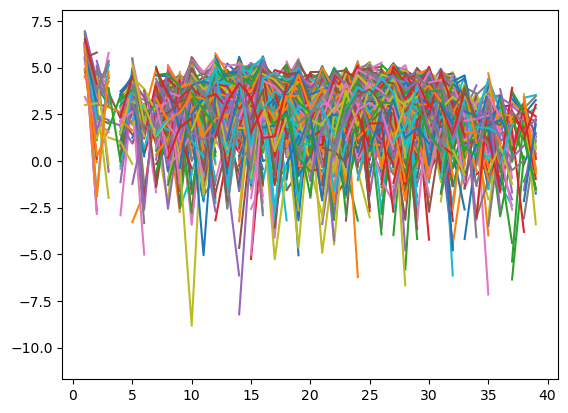

In [9]:
def show_mfcc(waveform, sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate=sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")

    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0, :, :].numpy())
    plt.draw()


show_mfcc(data_spk1[0][0], 16000)

In [27]:
%%capture trash


def create_spectrogram_images(trainloader, label_dir, new_sample_rate=8000):
    s = 0
    count = 0
    # make directory
    directory = f"./temp_data/spectrograms/{label_dir}/"
    if os.path.isdir(directory):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)

        for i, data in enumerate(trainloader):

            waveform = data[0]
            sample_rate = data[1]
            label = data[2]

            waveform_transformed = torchaudio.transforms.Resample(
                sample_rate, new_sample_rate
            )(waveform)

            # create transformed waveforms
            spectrogram_tensor = torchaudio.transforms.Spectrogram()(
                waveform_transformed
            )
            s += spectrogram_tensor.shape[-1]
            count += 1

            fig = plt.figure()
            plt.imsave(
                f"./temp_data/spectrograms/{label_dir}/spec_img{i}.png",
                spectrogram_tensor[0].log2()[0, :, :].numpy(),
                cmap="viridis",
            )

    return s / count


loader_spk1 = torch.utils.data.DataLoader(data_spk1, batch_size=1, shuffle=True)
loader_spk2 = torch.utils.data.DataLoader(data_spk2, batch_size=1, shuffle=True)

avg_len1 = create_spectrogram_images(loader_spk1, "spk1")
avg_len2 = create_spectrogram_images(loader_spk2, "spk2")

In [28]:
avg_len1
avg_len2

485.31

482.2156862745098

In [29]:
data_path = "./temp_data/spectrograms"  # looking in subfolder train

dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose(
        [transforms.Resize((201, 485)), transforms.ToTensor()]
    ),
)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 202
    Root location: ./temp_data/spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 485), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [30]:
class_map = dataset.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'spk1': 0, 'spk2': 1}



In [31]:
# split data to test and train
# use 80% to train
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

print("Training size:", len(train_dataset))
print("Testing size:", len(test_dataset))

Training size: 161
Testing size: 41


In [32]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in train_dataset]
Counter(train_classes)

Counter({1: 83, 0: 78})

In [33]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, num_workers=4, shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, num_workers=4, shuffle=True
)

In [69]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(354944, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, p=0.2, train=self.training)
        x = torch.relu(self.fc2(x))
        return torch.log_softmax(x, dim=1)


model = CNN().to(device)

summary(model, input_size=(8, 3, 201, 485))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [8, 2]                    --
├─Conv2d: 1-1                            [8, 32, 197, 481]         2,432
├─Conv2d: 1-2                            [8, 64, 94, 236]          51,264
├─Dropout2d: 1-3                         [8, 64, 94, 236]          --
├─Flatten: 1-4                           [8, 354944]               --
├─Linear: 1-5                            [8, 50]                   17,747,250
├─Linear: 1-6                            [8, 2]                    102
Total params: 17,801,048
Trainable params: 17,801,048
Non-trainable params: 0
Total mult-adds (G): 11.08
Input size (MB): 9.36
Forward/backward pass size (MB): 284.93
Params size (MB): 71.20
Estimated Total Size (MB): 365.49

In [74]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function


def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):

        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# Create the validation/test function


def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f"\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n")


epochs = 2

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 0.693147  [    0/  161]
loss: 0.693147  [   16/  161]
loss: 0.693147  [   32/  161]
loss: 0.693147  [   48/  161]
loss: 0.693147  [   64/  161]
loss: 0.693147  [   80/  161]
loss: 0.693147  [   96/  161]
loss: 0.693147  [  112/  161]
loss: 0.693147  [  128/  161]
loss: 0.693147  [  144/  161]
loss: 0.693147  [   20/  161]

Test Error:
acc: 53.7%, avg loss: 0.101436

Epoch 2
-------------------------------
loss: 0.693147  [    0/  161]
loss: 0.693147  [   16/  161]
loss: 0.693147  [   32/  161]
loss: 0.693147  [   48/  161]
loss: 0.693147  [   64/  161]
loss: 0.693147  [   80/  161]
loss: 0.693147  [   96/  161]
loss: 0.693147  [  112/  161]
loss: 0.693147  [  128/  161]
loss: 0.693147  [  144/  161]
loss: 0.693147  [   20/  161]

Test Error:
acc: 53.7%, avg loss: 0.101436

Done!


🔨